In [ ]:
%pip install celluloid
%pip install torch torchvision
import sys
sys.path.append('/content/drive/MyDrive/local_lipschitz-master')
import network_bound
import my_config

import torch
import torchvision
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from celluloid import Camera
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from sklearn import datasets
from sklearn.manifold import TSNE
import time


In [ ]:

def graph(network,text):
  data_p=example_data[0:2000]
  test_p=example_targets[0:2000]

  fig = plt.figure()
  x_pred, x_prev = network(data_p.to(device))
  vals= x_pred.detach().cpu().numpy()

  tsne = TSNE(n_components=3, perplexity=50, n_iter=300)
  X_tsne = tsne.fit_transform(vals)

  #ax = fig.add_subplot(1,2,2,projection='3d')
  ax = fig.add_subplot(projection='3d')
  scatter=  ax.scatter(
      xs=X_tsne[:, 0],
      ys=X_tsne[:, 1],
      zs=X_tsne[:, 2],
      c=test_p,
      cmap='tab20b',
      label=test_p
  )
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
  ax.add_artist(legend1)
  plt.title(text)

  #plt.show()

def graph_cam(network, si, beta):
  data_p=example_data[0:2000]
  test_p=example_targets[0:2000]

  x_pred, x_prev = network(data_p.to(device))
  vals= x_pred.detach().cpu().numpy()

  tsne = TSNE(n_components=3, perplexity=50, n_iter=300)
  X_tsne = tsne.fit_transform(vals)

  #ax = fig.add_subplot(1,2,2,projection='3d')
  ax.scatter(
      xs=X_tsne[:, 0],
      ys=X_tsne[:, 1],
      zs=X_tsne[:, 2],
      c=test_p,
      cmap='tab20b'
  )
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  text =str(si)+'  beta= '+ str(beta)
  plt.title(text)

  #plt.show()

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data=data.to(device)
      target=target.to(device)
      output, x_prev = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return correct / len(test_loader.dataset)

torch.Size([2048, 1, 28, 28])


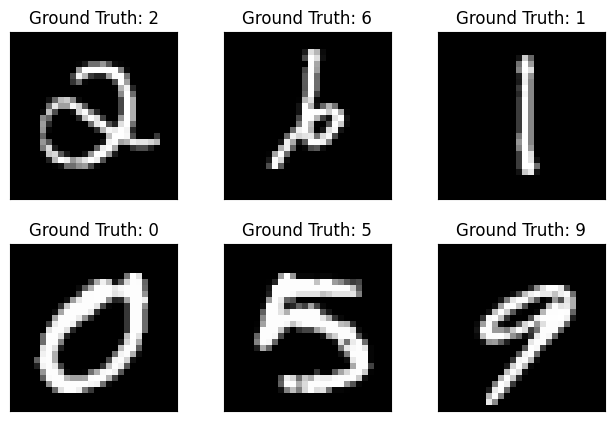

In [ ]:
epsi=0.01
batch_size_train = 2048
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.3
log_interval = 10

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./files/''/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.to(device)
example_targets.to(device)

print(example_data.shape)
#pause = input()

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128,10 )
        self.fc3 = nn.Linear(3, 10)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=False)
        self.flatten = nn.Flatten()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        #x = F.relu(x)
        x = self.relu(self.conv2(x))
        #x = F.relu(x)
        x = self.pool(x)
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        #x = F.relu(x)
        #x = self.dropout2(x)
        x = self.fc2(x)
        # x = F.relu(x)

        y=x
       # x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output,y

In [ ]:
class ClassDistancePenaltyLoss(nn.Module):
    def __init__(self, num_classes, norma):
        super(ClassDistancePenaltyLoss, self).__init__()
        self.num_classes = num_classes
        self.norma=norma

    def forward(self, x, t):
        vc=torch.zeros(1).to(device)
        for j in range (self.num_classes): #para cada clase

          cla=x[t==j].to(device)
          ccov=torch.cov(torch.t(cla))
          if self.norma:
              ncla=torch.linalg.vector_norm(torch.diag(ccov,0),ord=1)
              #ncla=torch.linalg.vector_norm(torch.diag(ccov,0),ord=2)
              #ncla=torch.linalg.vector_norm(torch.diag(ccov,0),ord=np.inf)
          else:
              ccov=torch.cov(torch.t(cla))
              ncla=torch.trace(ccov)
          vc=vc+ncla
        penalty2=0
        penalty1=vc/self.num_classes
        return penalty1, penalty2


In [ ]:
print('Inicia')
print(device)
exes=2000 #numero de ejemplos que se van a utilizar para el entrenamiento
norma=False # --- -Evaluamos con la NORMA o no ---------------


'''fig = plt.figure(figsize=(6,6),dpi=(1920/16))
ax = fig.add_subplot(projection='3d')
camera= Camera(fig)
'''
random_seed = 5900
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
network = Net().to(device)


optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
myloss=ClassDistancePenaltyLoss(10,norma)
n_epochs = 5
beta=0.9 #covarianza
alpha=0.0 #distancia entre medias
si= False  #<------------------------------------ACA ESTA EL PARAMETRO-----------
#optimizer = optim.Adagrad(network.parameters())
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
e=0
start_time = time.time()

for epoch in range(n_epochs):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      data=data.to(device)
      target=target.to(device)
      e=e+1
      optimizer.zero_grad()
      output, x_prev = network(data)
      loss = F.nll_loss(output, target)
      if si:
        p1,p2=myloss(x_prev,target)
        #loss=loss+beta*p1-alpha*torch.pow(15-p2,2)
        loss=loss+beta*p1-alpha*p2
        #loss=beta*p1#-alpha*p2 #sin medir la entropia
      salir = loss.item()

      loss.backward()
      optimizer.step()
      '''
      if salir<0.000000000005:
        break
      '''
      if batch_idx % log_interval == 0:
        #print('cov ', valor.detach().cpu().numpy(), 'beta= ', beta)
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch,1 * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

execution_time = (time.time() - start_time)
print('Execution time in seconds: ' + str(execution_time))
acc=test()


Inicia
cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3045, Accuracy: 873/10000 (9%)

Train Epoch: 0 [2048/60000 (0%)]	Loss: 2.304493
Train Epoch: 0 [2048/60000 (33%)]	Loss: 2.217216
Train Epoch: 0 [2048/60000 (67%)]	Loss: 2.107217
Train Epoch: 1 [2048/60000 (0%)]	Loss: 1.903257
Train Epoch: 1 [2048/60000 (33%)]	Loss: 1.574309
Train Epoch: 1 [2048/60000 (67%)]	Loss: 1.132455
Train Epoch: 2 [2048/60000 (0%)]	Loss: 0.768529
Train Epoch: 2 [2048/60000 (33%)]	Loss: 0.615145
Train Epoch: 2 [2048/60000 (67%)]	Loss: 0.523955
Train Epoch: 3 [2048/60000 (0%)]	Loss: 0.473424
Train Epoch: 3 [2048/60000 (33%)]	Loss: 0.446614
Train Epoch: 3 [2048/60000 (67%)]	Loss: 0.446852
Train Epoch: 4 [2048/60000 (0%)]	Loss: 0.365456
Train Epoch: 4 [2048/60000 (33%)]	Loss: 0.380699


In [ ]:
# construimos una clase para cálculo de Simulated Annealing

class annealing:
    def __init__(self,modelo, T,ro,dist,prob,itera):
        super(annealing, self).__init__()
        self.modelo=modelo
        self.ro=ro
        self.T=T
        self.dist=dist
        self.prob=prob
        self.itera=itera

    def lipx (self,x1,x2,): #dados dos valores de entrada, esta funcion calcula la L por definicion
        #L= np.linalg.norm(f1-f2,2)/np.linalg.norm(x1-x2,2)
        f1=self.modelo(x1)[1]#.cpu().detach().numpy()
        f2=self.modelo(x2)[1]#.cpu().detach().numpy()

        L= torch.linalg.matrix_norm(f1-f2,2)/torch.linalg.matrix_norm(x1-x2,2)
        #print(L)
        return L

    def P(self,x1,x2,xm1,xm2):
      Fi= self.lipx(x1,x2).cpu().detach().numpy()
      Fj= self.lipx(xm1,xm2).cpu().detach().numpy()

      #si la L es mayor entonces se queda con alta probabilidad de quedarse
      #si no calculamos una probabilidad que depende de la temperatura
      #se podria dejar solo la probabilidad basada en la temepratura
      if Fi>Fj:
          return 1
      else:
          return 0.1#np.exp(-(Fj-Fi)/T)

    def annea(self,x):
      f_lips=[]
      val=[]

      #estos puntos el fh como referencia para la bola de evaluacion
      xa1=x.cpu().detach().numpy() #xi is a point in hiperplaine to test  net and the liopschitz
      xa2=x.cpu().detach().numpy()+0.001

      #estos tensores representan los dos punta a y b para evaluar L inicialmente
      xm1=torch.tensor(xa1,dtype=torch.float32).to(device)
      xm2=torch.tensor(xa2,dtype=torch.float32).to(device)

      i=0

      while(i<self.itera):
        if i%100==0:
            pppp=0#print(i,self.T,self.prob)#,xm1.cpu().detach().numpy(),xm2.cpu().detach().numpy(),T)
        i=i+1
        w1 = np.random.uniform(low=-self.dist+xa1, high=self.dist+xa1, size=(x.shape))
        w1=torch.tensor(w1,dtype=torch.float32).to(device)
        w2 = np.random.uniform(low=-self.dist+xa2, high=self.dist+xa2, size=(x.shape))
        w2=torch.tensor(w2,dtype=torch.float32).to(device)

        #estos tensores son otros dos puntos aleatorios dentro de la bola
        #serviran para evaluar si la L aumenta, queremos hallar el maximo
        #de la L local en esa bola ...

        x1=w1#.cpu().detach().numpy()
        x2=w2#.cpu().detach().numpy()

        #se calcula la proba
        #print(x1,x2,xm1,xm2)
        prob=self.P(x1,x2,xm1,xm2)

        #al regresar con la probabilidad solo
        #debemos de evaluar de forma aleatoria si ese
        #valor se queda o se cambia

        ale=np.random.default_rng()

        if prob < ale.random():
              xm1=xm1
              xm2=xm2
        else:
              xm1=x1
              xm2=x2


        lx=self.lipx(xm1,xm2) #se llama a la funcion para sacar la L
       # print(lx)
        val.append(lx.cpu().detach().numpy())
        #self.T=self.T/self.ro #enfriando la temperatura en cada iteracion

        xa1=xm1.cpu().detach().numpy() #solo para extraer el valor numpy
        xa2=xm2.cpu().detach().numpy() #como nuevo punto de inicio

      lx=np.max(np.array(val)) #sacar el valor numpy nada mas para devolver
      #print('lx ', lx)
      return lx,val








In [ ]:


#---- Cálculo de Lipschitz  de cada una de las clases
import random
random.seed(10)

c=10 #numero de clases a hallar
m=10 #numero de muestras a tomar por cada clase

#estas lineas definen las capas para el analytical
relu =nn.ReLU(inplace=False)
flatten = nn.Flatten()
network.layers = [network.conv1, relu,
              network.conv2, relu,
              network.pool,
              flatten,
              network.fc1,relu,
              network.fc2]
eps = 0.1
batch_size = 32
lips=[] #guardamos las L de cada clase aca

#valores para annealing
T=1.1
ro=0.1
dist=0.01
prob=0.9
itera=100

metodo='annealing'

La=annealing(network, T,ro,dist,prob,itera)

for i in range(c): #para cada una de las clases
  xc=example_data[example_targets==i]
  #print(xc.shape)
  lc=torch.zeros(1).to(device)
  Lm=[]
  for j in range(m): #tomando solo una muestra de todos los ejemplos de la clase


    r=random.random()*xc.shape[0]
    r=int(r)

    x0=xc[r].to(device) #tomamos un ejemplo como punto de inicio
    x0=torch.reshape(x0,((1,1,28,28)))

    if metodo=='analytical':
      # calculate local Lipschitz bound Analitycal
      bound = network_bound.local_bound(network, x0, eps, batch_size=batch_size)
      np.append(Lm,bound[0].detach().cpu().numpy())

    if metodo=='annealing':
    #calculando local L con Annealing
      bound = La.annea(x0)
      #print('bound ', bound[0])
      Lm.append(bound[0])

  val=np.max(np.array(Lm))    #el maximo de las L
  lips.append(val.item())
  print('clase ',i)
  #print ('Lm ', Lm)



for i in range(c):
  print(lips[i],'\t')


x0=example_data[0].to(device)
x0=torch.reshape(x0,((1,1,28,28)))
# calculate local Lipschitz bound


bound = network_bound.local_bound(network, x0, eps, batch_size=batch_size)
print('\nLOCAL LIPSCHITZ UPPER BOUND -- Analytical')
print('epsilon:', eps)
print('bound:', bound,'\n')



In [ ]:
text = (str(si)+'  beta= '+ str(beta)+'\n time= '+str(execution_time)+
        '  acc= '+str(acc.detach().cpu().numpy())+'  \n epoc= '+ str(n_epochs) +
        '\n local lipschitz bound =' + str(bound)+' N= '+str(norma))

graph(network,text)
plt.show()

from IPython.display import Audio, display
display(Audio("/content/drive/MyDrive/sound.ogg", autoplay=True))

